In [41]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input

warnings.filterwarnings('ignore')

In [2]:
def data_prep(MildDementia, ModerateDementia, VerymildDementia, NonDemented):

    MildDementia= ["../input/imagesoasis/Data/Mild Dementia" + '/' +  MildDementia for MildDementia in MildDementia]
    ModerateDementia= ["../input/imagesoasis/Data/Moderate Dementia"  + '/' +  ModerateDementia for ModerateDementia in ModerateDementia]
    VerymildDementia= ["../input/imagesoasis/Data/Very mild Dementia"  + '/' +  VerymildDementia for VerymildDementia in VerymildDementia]
    NonDemented= ["../input/imagesoasis/Data/Non Demented"  + '/' +  NonDemented for NonDemented in NonDemented]

    labels = len(MildDementia)*['MildDementia'] + len(ModerateDementia)*['ModerateDementia'] + len(VerymildDementia)*['VerymildDementia'] + len(NonDemented)*['NonDemented']
    data = MildDementia + ModerateDementia + VerymildDementia + NonDemented

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

In [3]:
df = data_prep(os.listdir('../input/imagesoasis/Data/Mild Dementia'), os.listdir('../input/imagesoasis/Data/Moderate Dementia'),
               os.listdir('../input/imagesoasis/Data/Very mild Dementia'), os.listdir('../input/imagesoasis/Data/Non Demented'))

In [4]:
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.sample(10)

,Image_Path,Labels
4991,../input/imagesoasis/Data/Mild Dementia/OAS1_0...,MildDementia
52930,../input/imagesoasis/Data/Non Demented/OAS1_02...,NonDemented
74479,../input/imagesoasis/Data/Non Demented/OAS1_02...,NonDemented
17626,../input/imagesoasis/Data/Non Demented/OAS1_01...,NonDemented
4486,../input/imagesoasis/Data/Non Demented/OAS1_00...,NonDemented
37344,../input/imagesoasis/Data/Non Demented/OAS1_03...,NonDemented
55937,../input/imagesoasis/Data/Non Demented/OAS1_00...,NonDemented
57642,../input/imagesoasis/Data/Non Demented/OAS1_00...,NonDemented
71752,../input/imagesoasis/Data/Non Demented/OAS1_02...,NonDemented
85054,../input/imagesoasis/Data/Non Demented/OAS1_00...,NonDemented


In [6]:
def plot_images(class_label, df, num_images=5):

    class_df = df[df['Labels'] == class_label].head(num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()

    for i, (img_path) in enumerate(class_df['Image_Path']):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'{class_label} - Image {i+1}')

    plt.tight_layout()
    plt.show()

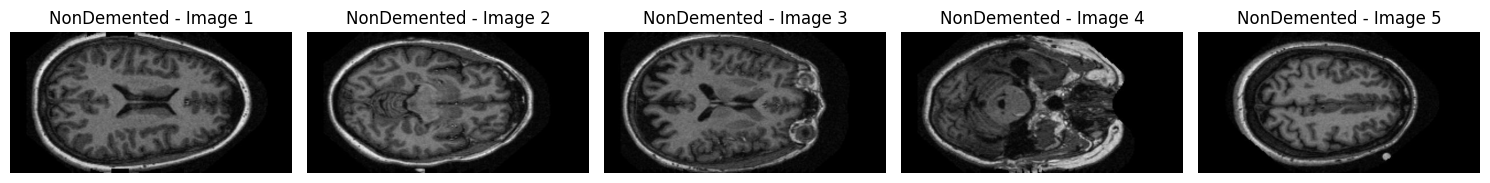

In [7]:
plot_images('NonDemented', df)

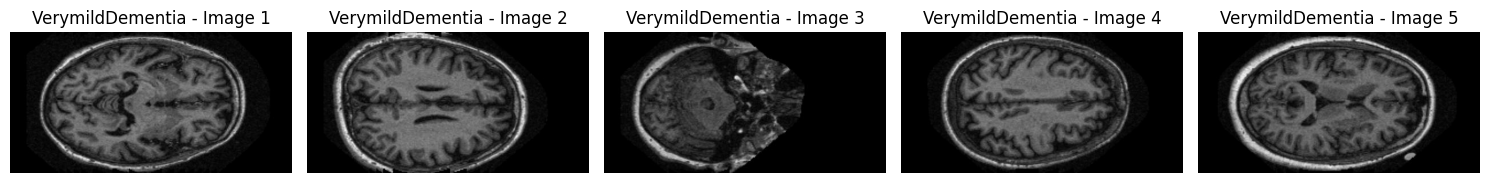

In [8]:
plot_images('VerymildDementia', df)

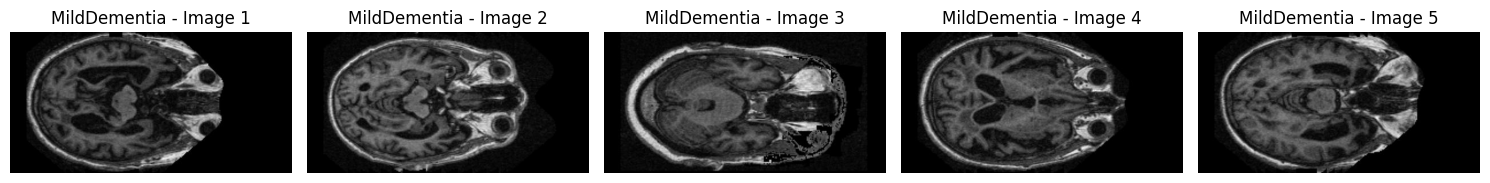

In [9]:
plot_images('MildDementia', df)

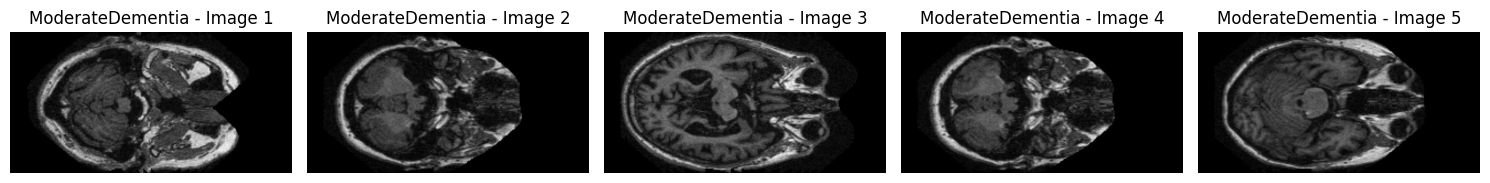

In [10]:
plot_images('ModerateDementia', df)

In [11]:
df.Labels.value_counts()

Labels
NonDemented         67222
VerymildDementia    13725
MildDementia         5002
ModerateDementia      488
Name: count, dtype: int64

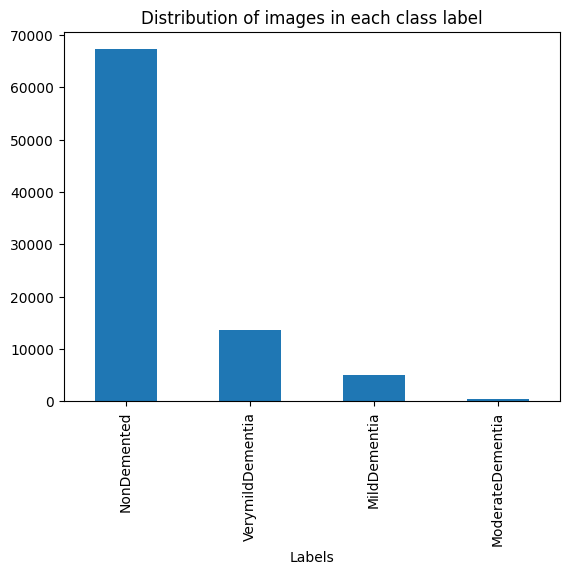

In [12]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label')
plt.show()

### Data is imbalanced hence reducing the data size by using the sample images from majority classes

In [13]:
df = df.groupby('Labels').apply(lambda x: x.sample(n=1000, random_state=42) if x['Labels'].iloc[0] in ['NonDemented', 'VerymildDementia', 'MildDementia'] else x)
df = df.reset_index(drop=True)

In [14]:
df.Labels.value_counts()

Labels
MildDementia        1000
NonDemented         1000
VerymildDementia    1000
ModerateDementia     488
Name: count, dtype: int64

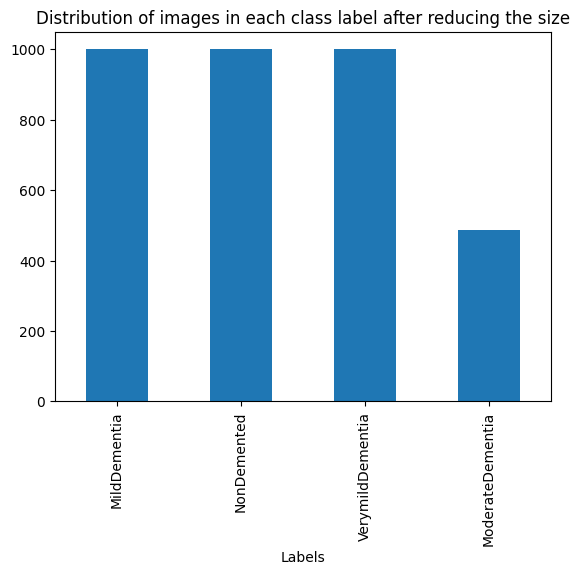

In [15]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label after reducing the size')
plt.show()

In [16]:
train, test = train_test_split(df, test_size = .30)

In [17]:
datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,                     # File paths are in the dataframe
    x_col='Image_Path',                 # Column with image file paths
    y_col='Labels',                     # Column with labels
    target_size=(224, 224),             # Resize images to 224x224
    batch_size=32,                      # Number of images to process in each batch
    class_mode='categorical',           # Classification task
    shuffle=True                        # Shuffle the data
)

Found 2441 validated image filenames belonging to 4 classes.


In [19]:
def augmented_images(generator, num_images=5):

    for i in range(num_images):
        img, label = next(generator)
        plt.figure(figsize=(5, 5))
        plt.imshow(img[0])
        plt.axis('off')
        plt.show()

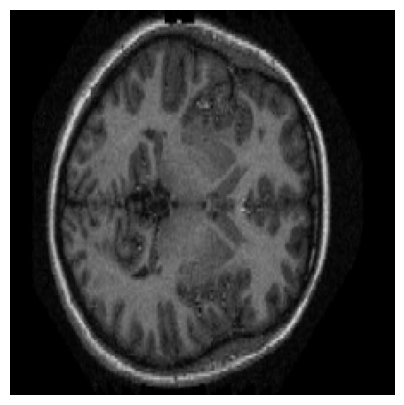

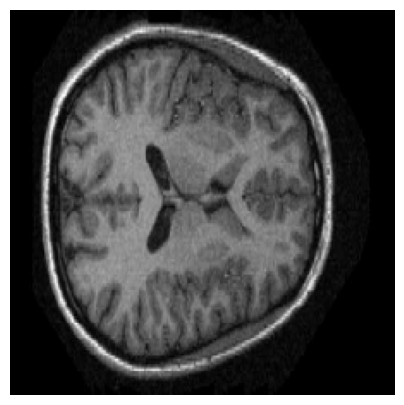

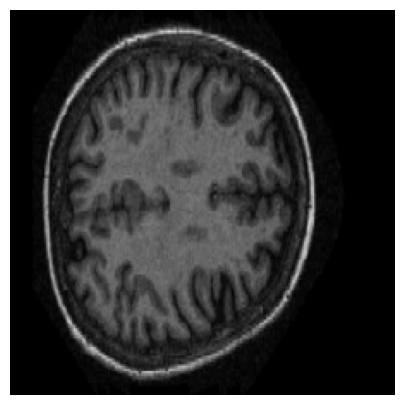

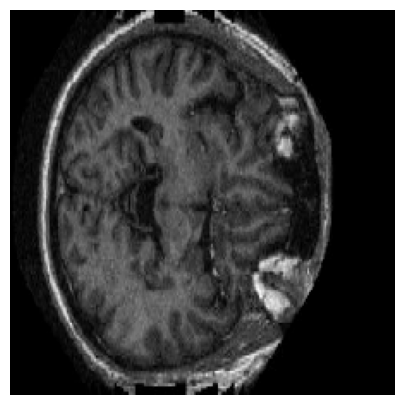

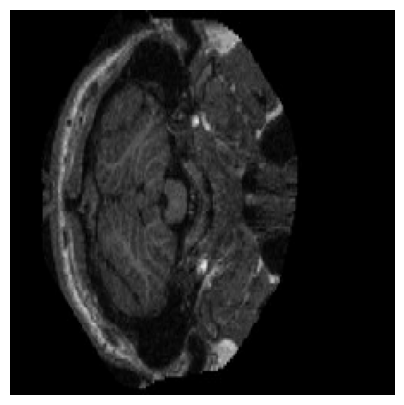

In [20]:
augmented_images(train_generator, num_images=5)

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,                      # File paths are in the dataframe
    x_col='Image_Path',                   # Column with image file paths
    y_col='Labels',                       # Column with labels
    target_size=(224, 224),               # Resize images to 224x224
    batch_size=32,                        # Number of images to process in each batch
    class_mode='categorical',             # Classification task
    shuffle=False                         # Do not shuffle test data
)

Found 1047 validated image filenames belonging to 4 classes.


In [23]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
hist = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.3250 - loss: 1.4215 - val_accuracy: 0.5778 - val_loss: 0.9979
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5673 - loss: 0.9435 - val_accuracy: 0.7584 - val_loss: 0.6225
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.7561 - loss: 0.6277 - val_accuracy: 0.8176 - val_loss: 0.4431
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.8304 - loss: 0.4243 - val_accuracy: 0.8548 - val_loss: 0.3825
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8667 - loss: 0.3522 - val_accuracy: 0.8586 - val_loss: 0.3052
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8880 - loss: 0.2779 - val_accuracy: 0.9207 - val_loss: 0.2268
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9284 - loss: 0.1843 - val_accuracy: 0.8854 - val_loss: 0.2841
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9344 - loss: 0.1698 - val_accuracy: 0.9226 -

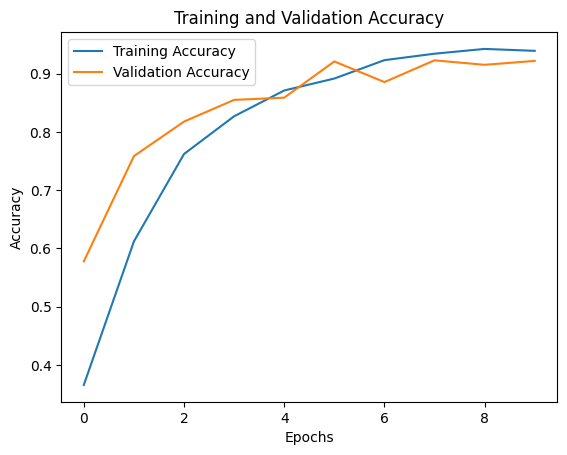

In [25]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

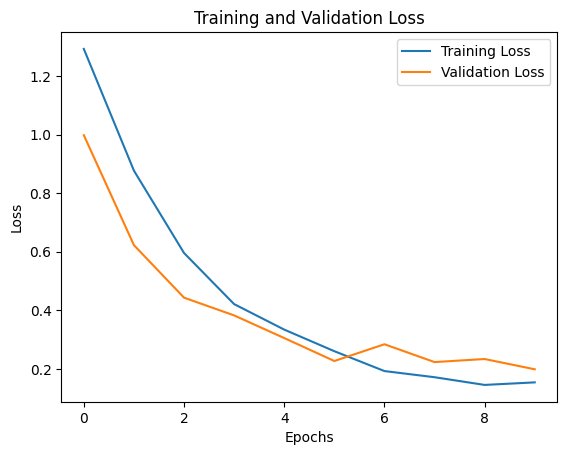

In [26]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [37]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth convolutional layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fifth convolutional layer
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,207,620 (12.24 MB)

 Trainable params: 3,207,620 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
hist = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.2834 - loss: 1.3760 - val_accuracy: 0.2722 - val_loss: 1.3642
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.2998 - loss: 1.3564 - val_accuracy: 0.2789 - val_loss: 1.3152
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.3643 - loss: 1.2838 - val_accuracy: 0.5339 - val_loss: 1.0330
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5450 - loss: 0.9999 - val_accuracy: 0.6705 - val_loss: 0.7511
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.6853 - loss: 0.7341 - val_accuracy: 0.6543 - val_loss: 0.7545
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.7078 - loss: 0.6578 - val_accuracy: 0.7631 - val_loss: 0.5710
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.7824 - loss: 0.5326 - val_accuracy: 0.7794 - val_loss: 0.5218
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8172 - loss: 0.4410 - val_accuracy: 0.8176 -

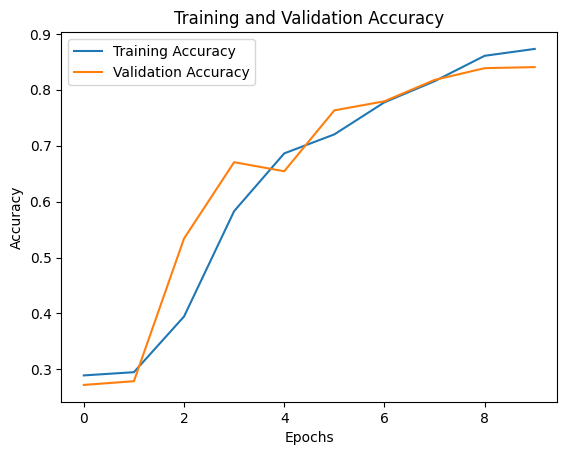

In [39]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

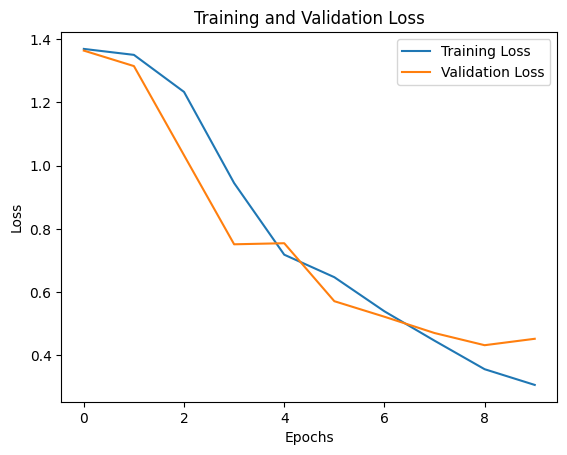

In [40]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [31]:
input_shape = (224, 224, 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
hist = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 513ms/step - accuracy: 0.2905 - loss: 2.5046 - val_accuracy: 0.3887 - val_loss: 1.2318
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - accuracy: 0.3613 - loss: 1.2762 - val_accuracy: 0.4604 - val_loss: 1.1538
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.3805 - loss: 1.1985 - val_accuracy: 0.5244 - val_loss: 1.1014
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.3627 - loss: 1.1883 - val_accuracy: 0.4957 - val_loss: 1.0707
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 0.4086 - loss: 1.1519 - val_accuracy: 0.5807 - val_loss: 1.0173
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 0.4027 - loss: 1.1493 - val_accuracy: 0.5960 - val_loss: 1.0361
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.4169 - loss: 1.1494 - val_accuracy: 0.5673 - val_loss: 0.9650
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.4241 - loss: 1.1250 - val_accu

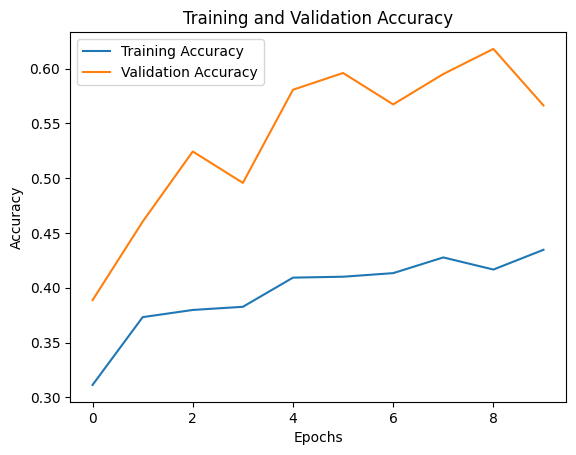

In [33]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

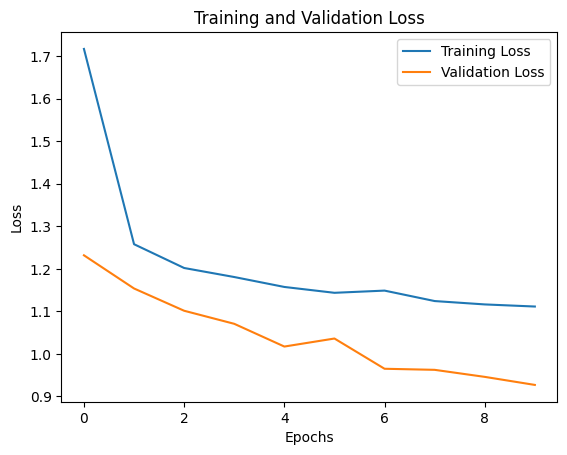

In [34]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [27]:
input_shape = (224, 224, 3)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 36,433,412 (138.98 MB)

 Trainable params: 12,845,700 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [28]:
hist = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 276ms/step - accuracy: 0.2746 - loss: 5.2193 - val_accuracy: 0.2779 - val_loss: 1.3798
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.2893 - loss: 1.3770 - val_accuracy: 0.2722 - val_loss: 1.3730
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.2933 - loss: 1.3702 - val_accuracy: 0.2722 - val_loss: 1.3677
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.2756 - loss: 1.3668 - val_accuracy: 0.2722 - val_loss: 1.3636
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.2874 - loss: 1.3610 - val_accuracy: 0.2722 - val_loss: 1.3606
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.2877 - loss: 1.3567 - val_accuracy: 0.2722 - val_loss: 1.3582
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.2982 - loss: 1.3565 - val_accuracy: 0.2722 - val_loss: 1.3564
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.3019 - loss: 1.3506 - val_accu

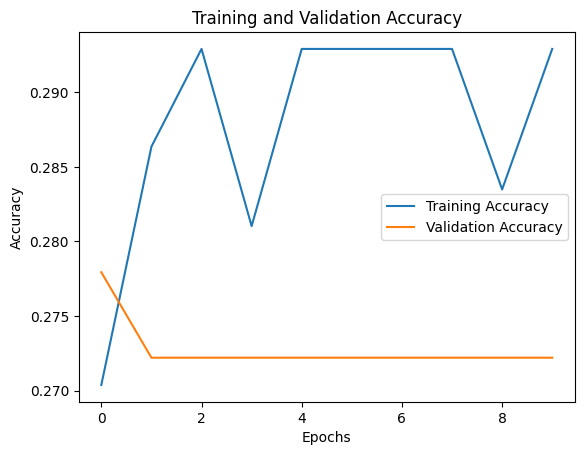

In [29]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

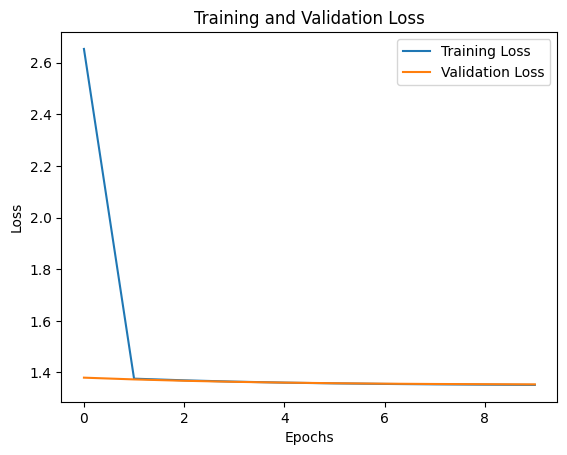

In [30]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [42]:
input_shape = (224, 224, 3)

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 71,216,644 (271.67 MB)

 Trainable params: 12,845,700 (49.00 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [43]:
hist = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 564ms/step - accuracy: 0.2877 - loss: 4.9903 - val_accuracy: 0.2779 - val_loss: 1.3807
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 370ms/step - accuracy: 0.2858 - loss: 1.3780 - val_accuracy: 0.2779 - val_loss: 1.3736
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 352ms/step - accuracy: 0.2902 - loss: 1.3705 - val_accuracy: 0.2779 - val_loss: 1.3683
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 349ms/step - accuracy: 0.2965 - loss: 1.3660 - val_accuracy: 0.2779 - val_loss: 1.3638
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 358ms/step - accuracy: 0.3070 - loss: 1.3572 - val_accuracy: 0.2779 - val_loss: 1.3606
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 355ms/step - accuracy: 0.2835 - loss: 1.3618 - val_accuracy: 0.2779 - val_loss: 1.3584
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 352ms/step - accuracy: 0.3011 - loss: 1.3599 - val_accuracy: 0.2779 - val_loss: 1.3567
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 353ms/step - accuracy: 0.2954 - loss: 1.3488 - val_accu

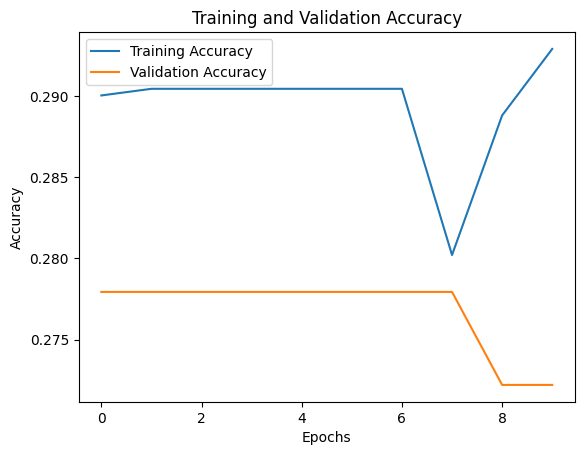

In [44]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

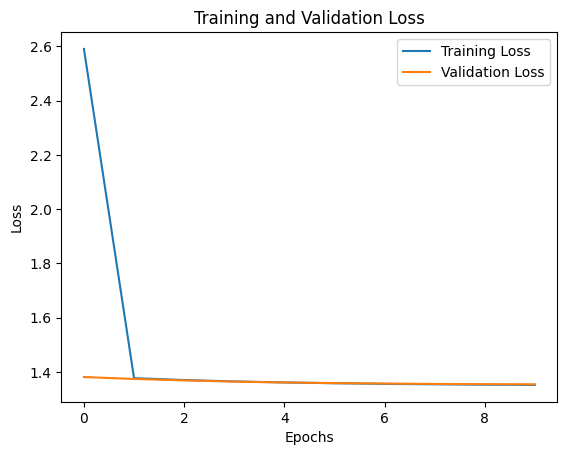

In [45]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()